# Changing image according to sound entropy

## Assumptions

Here we will try to study how much information is needed to guess the next note in a song. Similarly to Shannon's theory about the encoding of the English alphabet - looking at the relative frequencies of the most and least used letters. 

Here instead of letters in the alphabet, we will use pitches, such that the cardinality of our alphabet is 12. Therefore, words are chords, sentences are musical phrases and paragraphs are an entire song.

### Definition
_Entropy_: Uncertainty, or information, contained in a message. Measure of likeliness that a sent message will not convey the intended meaning it was given, and it is equal to the number of bits per symbol of improbability that the message contains.

### What to expect
A song that has very consistent rhythms would have consistent periodicity between the onsets (= beginning of a musical note). A well-played song, in terms of pitch, the resulting spectogram would contain peaks at the frequencies of that song's scale. All in all, we are using two intermediate of analyses, a beat histogram and a frequency spectogram. But, we also wish to extract the consistency ouf of both features. That's where Entropy comes in:

\begin{equation}
Entropy = - \sum{x \cdot log(x)}
\end{equation}

The more periodic a source is, the lower the entropy will be. Entropy is higher when values are clustered, and lower when values are random and independent.  

### Entropy in Rythm and Pitch

By inspiration of the work done in "Entropy and the Estimation of Musical Ability" (2016) from Andrew Russell, we will study and extract the _rythmic entropy_ and the _tonal entropy_. Russell uses it as way to find the "musical ability" of a musician in an audio recording. 

In [48]:
import scipy.io.wavfile
import scipy.stats
from os.path import abspath
import subprocess
import numpy as np
from os.path import join as p_join
import matplotlib.pyplot as plt
import librosa

data_fpath = p_join(abspath(''), 'data')
# Song choice #
song_title1 = "Patti"
song1 = song_title1 +".wav"

song_title2 = "harry_styles"
song2 = song_title2 + ".wav"

song_title3 = "stravinsky"
song3 = song_title3 + ".wav"

###############

In [50]:
# we will need some real-world audio for some examples. 
from IPython.display import Audio
from scipy.io import wavfile

# Patti
audio_patti = p_join(data_fpath, song1)
audio_sample_patti, sr_patti = librosa.load(audio_patti, sr = None)

# Watermelon Sugar
audio_watermelon = p_join(data_fpath, song2)
audio_sample_watermelon, sr_watermelon = librosa.load(audio_watermelon, sr = None)

# Stravinsky - Rite of Springs
audio_stravinsky = p_join(data_fpath, song3)
audio_sample_stravinsky, sr_stravinsky = librosa.load(audio_stravinsky, sr = None)


In [42]:
Audio(audio_patti, rate = sr_patti)

In [43]:
Audio(audio_watermelon, rate = sr_watermelon)

In [51]:
Audio(audio_stravinsky, rate = sr_stravinsky)

#### Onset detection
We use an off-the-shelf onset detector: "aubio" used for the extraction of annotations from audio signals. **If the volume of the audio is louder than the silence threshold value, the peak is declared an onset**.  Russell develops in his paper more about how an onset is computed through this package. 

In [13]:
def compute_rhythm(song):
    """
    Outputs a list of timestamps, in seconds, for which 
    onsets were detected by using the default onset 
    detection function. 
    """
    # Onsets
    onsets_string = subprocess.check_output(['aubioonset', '-i', song])
    onsets = onsets_string.decode("utf-8").strip().split('\n')
    onsets = [float(onset) for onset in onsets]
    # Diffs
    # Gives us a list of timings between onsets
    diffs = np.abs(np.diff(onsets)) # Calculate the n-th discrete difference along the given axis
    grid = np.linspace(0, 10, 1000)
    density = scipy.stats.gaussian_kde(diffs)
    hist = density(grid)
    # Entropy
    entropy = scipy.stats.entropy(hist) # Shannon's entropy 

    return {
    'entropy': entropy,
    'recording': song,
    'onsets': onsets,
    'diffs': diffs,
    'hist': hist,
    'grid': grid
    }

In [52]:
res1 = compute_rhythm(p_join(data_fpath, song1))
res2 = compute_rhythm(p_join(data_fpath, song2))
res3 = compute_rhythm(p_join(data_fpath, song3))

In [31]:
res2

{'entropy': 3.9801131279267126,
 'recording': '/home/simonl/Desktop/ComputersAndMusic/AudioImagers/data/harry_styles.wav',
 'onsets': [0.0,
  0.133771,
  0.445146,
  0.61075,
  0.756896,
  0.921854,
  1.068479,
  1.22975,
  1.301271,
  1.547938,
  1.864625,
  1.978167,
  2.643229,
  2.956563,
  3.123542,
  3.252896,
  3.436063,
  3.580583,
  3.738458,
  3.806854,
  4.057042,
  4.211854,
  4.367188,
  4.497229,
  5.161,
  5.469458,
  5.625834,
  5.784,
  5.9505,
  6.093542,
  6.241396,
  6.332313,
  6.888333,
  7.347729,
  7.671333,
  7.838729,
  7.980437,
  8.141334,
  8.296812,
  8.593458,
  8.76825,
  8.828896,
  9.086166,
  9.400167,
  9.514354,
  10.183958],
 'diffs': array([0.133771, 0.311375, 0.165604, 0.146146, 0.164958, 0.146625,
        0.161271, 0.071521, 0.246667, 0.316687, 0.113542, 0.665062,
        0.313334, 0.166979, 0.129354, 0.183167, 0.14452 , 0.157875,
        0.068396, 0.250188, 0.154812, 0.155334, 0.130041, 0.663771,
        0.308458, 0.156376, 0.158166, 0.1665  , 

In [16]:
def plotAudio(plt, recording):
  sampling_rate, audio = scipy.io.wavfile.read(recording.name)
  duration = len(audio) / sampling_rate

  plt.axis([0, duration, -1, 1])

  audio = audio.mean(axis = 1)
  audio /= np.max(audio)
  audio = scipy.signal.resample(audio, 12000)
  audio = np.asarray(audio, dtype=np.double)
  time = np.linspace(0, duration, num = len(audio))
  plt.plot(time, audio, 'b')

In [17]:
def generateOnsetLocations(values):
    print('ol')

    recording = values['recording']
    onsets = values['onsets']

    plt.title('Onset Locations')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plotAudio(plt, recording)
    for onset in onsets:
        plt.plot([onset, onset], [-1, 1], 'r')

In [18]:
def generateOnsetDiffs(values):
    print('od')

    onsets = values['onsets']
    diffs = values['diffs']

    plt.title('Onset Diffs')
    plt.ylabel('Onset Time Difference (s)')
    plt.xlabel('Time (s)')
    graphDiffs = np.append(diffs, [0])
    plt.plot(onsets, graphDiffs)
    plt.show()

In [19]:
def generateOnsetHistogram(values):
    print('oh')

    diffs = values['diffs']

    plt.title('Onset Diff Histogram')
    plt.ylabel('Count')
    plt.xlabel('Onset Time Difference (s)')
    plt.hist(diffs, bins=500, normed=True)

#### Parzen smoothing

In [73]:
def generateSmoothedOnsetHistogram(values,ax):
    """
    Corrects the statistical errors in the observation
    of the onsets. We use Gaussian kernels as a specific 
    shape in estimating the actual data's shape (since we
    assume the musicians' mistakes are normally distributed).
    """
    print('soh')

    diffs = values['diffs']
    hist = values['hist']
    grid = values['grid']

    ax.set_title('Smoothed Onset Diff Histogram')
    ax.set_ylabel('Count')
    ax.set_xlabel('Onset Time Difference (s)')
    bins = ax.hist(diffs, bins=300, density=True)
    histNorm = hist / np.max(hist) * np.max(bins[0])
    end = [i for i, v in enumerate(hist) if v > 1e-4][-1]
    ax.plot(grid[:end], histNorm[:end], 'g-')

od


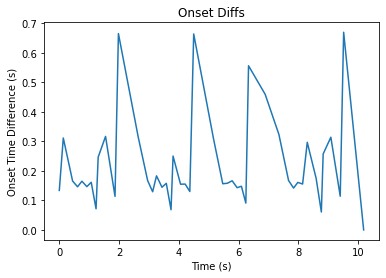

In [87]:
generateOnsetDiffs(res2)

soh
soh
soh


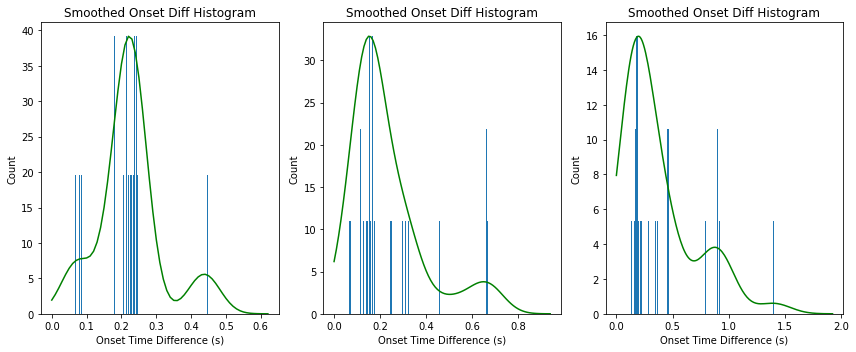

In [98]:
fig, axes = plt.subplots(1,3, tight_layout = True, figsize = (12,5))
axes.flatten()

generateSmoothedOnsetHistogram(res1, axes[0])
generateSmoothedOnsetHistogram(res2, axes[1])
generateSmoothedOnsetHistogram(res3, axes[2])


The blue bars of the graph represent the onset difference while the green line represents the Parzen smoothed probability density function.
We can see on the left-most plot, the onset time difference is mainly around 0.23 s. In other words, most onsets occurring in the song appear at an interval of 0.23s. 

In [58]:
print(res1['entropy'])
print(res2['entropy'])
print(res3['entropy'])

3.55770699764214
3.9801131279267126
4.645718400721778
